Cheking the dataset path

In [ ]:
import os

dataset_path = r"/content/TMDB user movie ratings.csv"


def validate_dataset_path(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"The dataset file was not found at: {path}")
    print(f"Dataset path exists: {path}")
validate_dataset_path(dataset_path)


Dataset path exists: /content/TMDB user movie ratings.csv


Loading Dataset

In [ ]:

def load_dataset(path):
    """
    Load the dataset from the given path and handle any issues.
    """
    data = pd.read_csv(path)
    print(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
    return data

dataset = load_dataset(dataset_path)

print("Preview of the loaded dataset:")
print(dataset.head())


Dataset loaded successfully with 884 rows and 4 columns.
Preview of the loaded dataset:
   user_id  media_id  rating                   title
0        1     27205     8.3               Inception
1        1    157336     8.1            Interstellar
2        1       155     8.5         The Dark Knight
3        1    299536     8.3  Avengers: Infinity War
4        1       550     7.9              Fight Club


Adjusting Rating Scale from 1-5

In [ ]:
import pandas as pd


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


if 'rating' in dataset.columns:
    def adjust_rating_scale(data, column, new_min=1, new_max=5):
        col = data[column]
        scaled_col = (col - col.min()) / (col.max() - col.min())  # Normalize to 0-1
        data[column] = (scaled_col * (new_max - new_min) + new_min).round(2)
        print(f"Ratings scaled to range {new_min}-{new_max}.")
        return data

    dataset = adjust_rating_scale(dataset, column='rating')

    print("Adjusted dataset preview:")
    print(dataset.head())
else:
    print("'rating' column not found in dataset.")


Ratings scaled to range 1-5.
Adjusted dataset preview:
   user_id  media_id  rating                   title
0        1     27205    2.83               Inception
1        1    157336    2.50            Interstellar
2        1       155    3.17         The Dark Knight
3        1    299536    2.83  Avengers: Infinity War
4        1       550    2.17              Fight Club


Save the Adjustments

In [ ]:
import os

def save_adjusted_dataset(dataframe, file_path):

    output_dir = os.path.join(os.path.dirname(file_path), "a/content")
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, "tmdb_movies_ratings_adjusted.xlsx")
    dataframe.to_excel(output_file, index=False)
    print(f"File saved successfully at: {output_file}")
    return output_file

adjusted_dataset_path = save_adjusted_dataset(dataset, dataset_path)

print("Dataset saved:", adjusted_dataset_path)


File saved successfully at: /content/a/content/tmdb_movies_ratings_adjusted.xlsx
Dataset saved: /content/a/content/tmdb_movies_ratings_adjusted.xlsx


 Requirements for Both User-Based and Item-Based CF

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


if 'rating' in dataset.columns:
    def adjust_rating_scale(data, column, new_min=1, new_max=5):
        col = data[column]
        scaled_col = (col - col.min()) / (col.max() - col.min())  # Normalize to 0-1
        data[column] = (scaled_col * (new_max - new_min) + new_min).round(2)
        print(f"Ratings scaled to range {new_min}-{new_max}.")
        return data

    dataset = adjust_rating_scale(dataset, column='rating')

    print("Adjusted dataset preview:")
    print(dataset.head())
else:
    print("'rating' column not found in dataset.")



Ratings scaled to range 1-5.
Adjusted dataset preview:
   user_id  media_id  rating                   title
0        1     27205    2.83               Inception
1        1    157336    2.50            Interstellar
2        1       155    3.17         The Dark Knight
3        1    299536    2.83  Avengers: Infinity War
4        1       550    2.17              Fight Club


In [ ]:
def count_unique_users_and_items(dataframe, user_col="user_id", item_col="media_id"):

    users_count = dataframe[user_col].nunique()
    items_count = dataframe[item_col].nunique()
    print(f"Unique users: {users_count}")
    print(f"Unique items: {items_count}")
    return users_count, items_count

users_count, items_count = count_unique_users_and_items(dataset)

Unique users: 60
Unique items: 86


In [ ]:
import pandas as pd


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


tnu = dataset['user_id'].nunique()
tni = dataset['media_id'].nunique()

# Print results
print(f"Total number of users (tnu): {tnu}")
print(f"Total number of items (tni): {tni}")


Total number of users (tnu): 60
Total number of items (tni): 86


Number of ratings for every product:
media_id
13         14
28         10
73         10
101         6
105         9
           ..
724089      9
761053      9
995133     11
1084736     9
1184918     9
Name: rating, Length: 86, dtype: int64


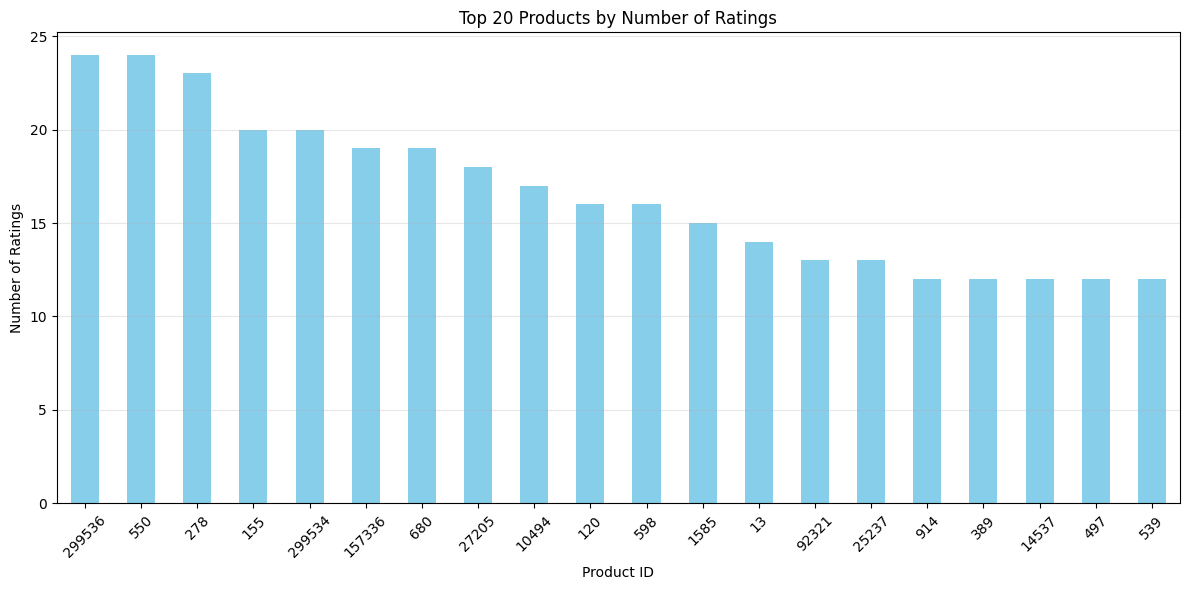

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


ratings_per_product = dataset.groupby('media_id')['rating'].count()


print("Number of ratings for every product:")
print(ratings_per_product)


plt.figure(figsize=(12, 6))
ratings_per_product.sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 Products by Number of Ratings")
plt.xlabel("Product ID")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()



In [ ]:
import pandas as pd
import numpy as np


dataset_path = "/content/TMDB user movie ratings.csv"


def create_user_item_matrix(data):

    unique_users = data['user_id'].unique()
    unique_items = data['media_id'].unique()
    matrix = pd.DataFrame(np.nan, index=unique_users, columns=unique_items)

    for _, row in data.iterrows():
        matrix.at[row['user_id'], row['media_id']] = row['rating']
    return matrix

user_item_matrix = create_user_item_matrix(dataset)


def calculate_missing_ratings(matrix):
    return matrix.isna().sum(axis=1)

def find_closest_user(missing_ratings, target):
    return missing_ratings.iloc[(missing_ratings - target).abs().argsort()].index[0]

def select_users_with_specific_missing_ratings(matrix):
    missing_ratings = calculate_missing_ratings(matrix)
    if len(missing_ratings) < 3:
        raise ValueError("Not enough users to select 3 distinct users.")
    U1 = find_closest_user(missing_ratings, 2)
    U2 = find_closest_user(missing_ratings, 3)
    U3 = find_closest_user(missing_ratings, 5)
    selected_users = list({U1, U2, U3})
    print(f"Selected users: {selected_users} (closest to 2, 3, and 5 missing ratings).")
    return selected_users

selected_users = select_users_with_specific_missing_ratings(user_item_matrix)



Selected users: [60] (closest to 2, 3, and 5 missing ratings).


In [ ]:
import pandas as pd


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)

unique_users = dataset['user_id'].unique()
unique_items = dataset['media_id'].unique()


import numpy as np
user_item_matrix = pd.DataFrame(np.nan, index=unique_users, columns=unique_items)


for _, row in dataset.iterrows():
    user_item_matrix.at[row['user_id'], row['media_id']] = row['rating']


print("User-Item Matrix created:")
print(user_item_matrix.head())


User-Item Matrix created:
   27205   157336  155     299536  550     680     13      278     299534  \
1     8.3     8.1     8.5     8.3     7.9     7.6     8.9     9.4     7.7   
2     8.9     8.1     8.3     8.6     8.3     8.2     8.1     8.6     8.4   
3     8.9     8.2     8.1     8.6     9.3     7.9     7.9     9.5     8.0   
4     8.4     8.3     7.9     8.7     9.4     8.0     9.0     8.7     9.2   
5     8.1     8.6     9.5     8.6     8.2     9.3     8.9     8.3     7.8   

   120     ...  14537   265177  101     244786  504253  11216   207     \
1     8.1  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     9.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3     8.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     8.9  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5     7.8  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   42269   423     995133  
1     NaN     NaN     NaN  
2     NaN 

In [ ]:
import pandas as pd
import numpy as np


def calculate_missing_ratings_per_user(matrix):

    return matrix.isna().sum(axis=1)


def get_user_closest_to_target(missing_ratings, target, excluded_users):


    filtered_ratings = missing_ratings.drop(index=excluded_users, errors='ignore')
    closest_user = filtered_ratings.iloc[(filtered_ratings - target).abs().argsort()].index[0]
    return closest_user


def select_users_with_missing_targets(matrix, targets=[2, 3, 5]):

    missing_ratings = calculate_missing_ratings_per_user(matrix)
    selected_users = []

    for target in targets:
        closest_user = get_user_closest_to_target(missing_ratings, target, excluded_users=selected_users)
        selected_users.append(closest_user)

    print(f"Selected users: {selected_users} (closest to {targets} missing ratings).")
    return selected_users


def create_user_item_matrix(data):

    unique_users = data['user_id'].unique()
    unique_items = data['media_id'].unique()
    matrix = pd.DataFrame(np.nan, index=unique_users, columns=unique_items)

    for _, row in data.iterrows():
        matrix.at[row['user_id'], row['media_id']] = row['rating']
    return matrix

dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


user_item_matrix = create_user_item_matrix(dataset)


selected_users = select_users_with_missing_targets(user_item_matrix)


Selected users: [60, 41, 11] (closest to [2, 3, 5] missing ratings).


In [ ]:
import pandas as pd
import numpy as np


def calculate_missing_percentage_per_item(matrix):

    total_users = matrix.shape[0]
    missing_count = matrix.isna().sum(axis=0)
    return (missing_count / total_users) * 100


def get_item_closest_to_target(missing_percentages, target, excluded_items):

    filtered_percentages = missing_percentages.drop(index=excluded_items, errors='ignore')
    closest_item = filtered_percentages.iloc[(filtered_percentages - target).abs().argsort()].index[0]
    return closest_item

def select_items_with_missing_percentages(matrix, targets=[4, 10]):

    missing_percentages = calculate_missing_percentage_per_item(matrix)
    selected_items = []

    for target in targets:
        closest_item = get_item_closest_to_target(missing_percentages, target, excluded_items=selected_items)
        selected_items.append(closest_item)

    print(f"Selected items: I1={selected_items[0]} (closest to {targets[0]}%), "
          f"I2={selected_items[1]} (closest to {targets[1]}%).")
    return selected_items

def create_user_item_matrix(data):

    unique_users = data['user_id'].unique()
    unique_items = data['media_id'].unique()
    matrix = pd.DataFrame(np.nan, index=unique_users, columns=unique_items)

    for _, row in data.iterrows():
        matrix.at[row['user_id'], row['media_id']] = row['rating']
    return matrix


dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


user_item_matrix = create_user_item_matrix(dataset)


selected_items = select_items_with_missing_percentages(user_item_matrix)


Selected items: I1=299536 (closest to 4%), I2=550 (closest to 10%).


In [ ]:
import pandas as pd
import numpy as np


def get_rated_items(matrix, user):

    return set(matrix.loc[user].dropna().index)


def compare_rated_items(user_items, other_user_items):

    return user_items.intersection(other_user_items)


def analyze_co_rated_items(matrix, user):

    user_items = get_rated_items(matrix, user)
    no_common_users = 0
    no_coRated_items = len(user_items)

    print(f"\nItems rated by User {user}: {user_items}")

    for other_user in matrix.index:
        if user != other_user:  # Avoid self-comparison
            other_user_items = get_rated_items(matrix, other_user)
            shared_items = compare_rated_items(user_items, other_user_items)

            if len(shared_items) == 0:
                no_common_users += 1
            else:
                print(f"User {user} and User {other_user} share {len(shared_items)} items: {shared_items}")

    return {'No_common_users': no_common_users, 'No_coRated_items': no_coRated_items}

# Function to count co-rated items and analyze overlap for multiple users
def count_co_rated_items_with_overlap(matrix, selected_users):

    co_rated_counts = {}

    for user in selected_users:
        co_rated_counts[user] = analyze_co_rated_items(matrix, user)

    print(f"\nCo-rated counts for selected users: {co_rated_counts}")
    return co_rated_counts


co_rated_counts = count_co_rated_items_with_overlap(user_item_matrix, selected_users)



Items rated by User 60: {129, 389, 25237, 278, 539, 155, 550, 630566, 423, 18491, 995133, 27205, 4935, 378064, 598, 346, 761053, 255709, 497, 121}
User 60 and User 1 share 4 items: {155, 27205, 550, 278}
User 60 and User 2 share 4 items: {155, 27205, 550, 278}
User 60 and User 3 share 4 items: {155, 27205, 550, 278}
User 60 and User 4 share 4 items: {155, 27205, 550, 278}
User 60 and User 5 share 4 items: {155, 27205, 550, 278}
User 60 and User 6 share 4 items: {155, 27205, 550, 278}
User 60 and User 7 share 4 items: {155, 27205, 550, 278}
User 60 and User 8 share 4 items: {155, 27205, 550, 278}
User 60 and User 9 share 4 items: {155, 27205, 550, 278}
User 60 and User 10 share 4 items: {155, 27205, 550, 278}
User 60 and User 11 share 6 items: {550, 4935, 378064, 497, 18491, 255709}
User 60 and User 12 share 1 items: {25237}
User 60 and User 13 share 5 items: {27205, 4935, 497, 25237, 18491}
User 60 and User 14 share 5 items: {27205, 389, 630566, 346, 539}
User 60 and User 15 share 5 i

In [ ]:
import numpy as np


def extract_co_rated_values(co_rated_counts):

    no_common_users = [count['No_common_users'] for count in co_rated_counts.values()]
    no_coRated_items = [count['No_coRated_items'] for count in co_rated_counts.values()]
    return no_common_users, no_coRated_items


def combine_values_to_2d_array(no_common_users, no_coRated_items):

    return np.column_stack((no_common_users, no_coRated_items))


def generate_2d_array(co_rated_counts):


    no_common_users, no_coRated_items = extract_co_rated_values(co_rated_counts)


    matrix = combine_values_to_2d_array(no_common_users, no_coRated_items)


    print("\nGenerated 2D Array of co-rated counts (rows=users, columns=['No_common_users', 'No_coRated_items']):")
    print(matrix)
    return matrix


co_rated_matrix = generate_2d_array(co_rated_counts)



Generated 2D Array of co-rated counts (rows=users, columns=['No_common_users', 'No_coRated_items']):
[[ 0 20]
 [ 0 20]
 [ 1 20]]


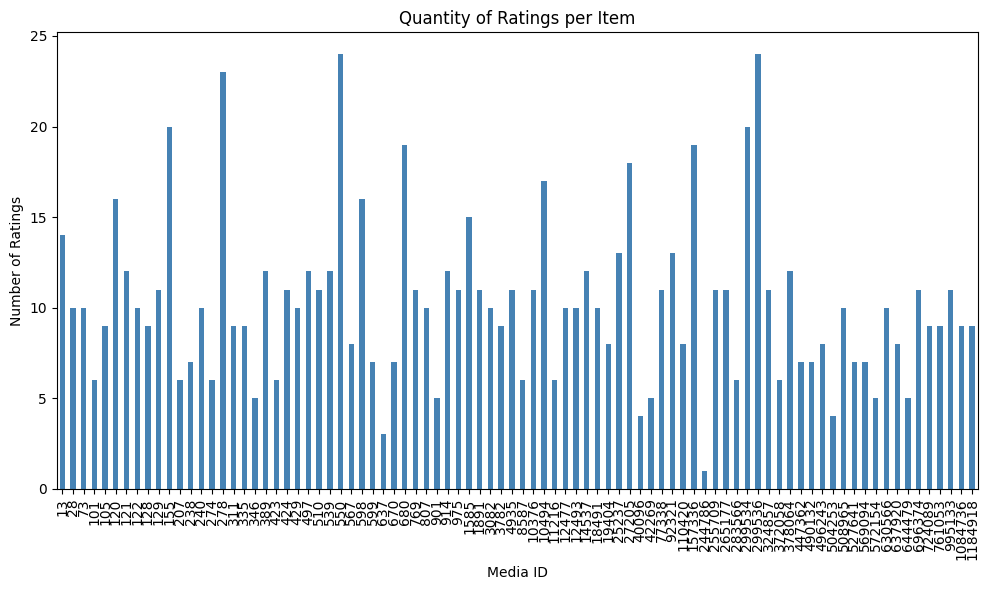

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


def compute_ratings_per_item(data):
    """
    Compute the number of ratings for each item.
    """
    return data.groupby('media_id')['rating'].count()


def plot_ratings_distribution(ratings_per_item):
    """
    Plot the quantity of ratings for every item in the dataset.
    """
    plt.figure(figsize=(10, 6))
    ratings_per_item.plot(kind='bar', color='steelblue')
    plt.title("Quantity of Ratings per Item")
    plt.xlabel("Media ID")
    plt.ylabel("Number of Ratings")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


ratings_per_item = compute_ratings_per_item(dataset)

plot_ratings_distribution(ratings_per_item)


In [ ]:
import pandas as pd
import numpy as np


def calculate_threshold_items(total_items, threshold):

    return int(total_items * threshold)


def get_rated_items_for_user(matrix, user):

    return set(matrix.loc[user].dropna().index)

def count_co_rated_users(matrix, active_user, threshold_items):

    active_user_items = get_rated_items_for_user(matrix, active_user)
    co_rated_user_count = 0

    for other_user in matrix.index:
        if active_user != other_user:
            other_user_items = get_rated_items_for_user(matrix, other_user)
            shared_items_count = len(active_user_items.intersection(other_user_items))
            if shared_items_count >= threshold_items:
                co_rated_user_count += 1
    return co_rated_user_count


def max_co_rated_users(matrix, selected_users, threshold=0.3):

    total_items = matrix.shape[1]
    threshold_items = calculate_threshold_items(total_items, threshold)
    max_users = {}

    for user in selected_users:
        co_rated_user_count = count_co_rated_users(matrix, user, threshold_items)
        max_users[user] = co_rated_user_count

    print(f"Maximum number of users co-rating at least {threshold * 100}% items:")
    print(max_users)
    return max_users


threshold = 0.3
max_users = max_co_rated_users(user_item_matrix, selected_users, threshold)


Maximum number of users co-rating at least 30.0% items:
{60: 0, 41: 0, 11: 0}


In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr


In [ ]:
import pandas as pd

dataset_path = "/content/TMDB user movie ratings.csv"
dataset = pd.read_csv(dataset_path)


if 'rating' in dataset.columns:
    def adjust_rating_scale(data, column, new_min=1, new_max=5):
        col = data[column]
        scaled_col = (col - col.min()) / (col.max() - col.min())  # Normalize to 0-1
        data[column] = (scaled_col * (new_max - new_min) + new_min).round(2)
        print(f"Ratings scaled to range {new_min}-{new_max}.")
        return data

    dataset = adjust_rating_scale(dataset, column='rating')


    print("Adjusted dataset preview:")
    print(dataset.head())
else:
    print("'rating' column not found in dataset.")


Ratings scaled to range 1-5.
Adjusted dataset preview:
   user_id  media_id  rating                   title
0        1     27205    2.83               Inception
1        1    157336    2.50            Interstellar
2        1       155    3.17         The Dark Knight
3        1    299536    2.83  Avengers: Infinity War
4        1       550    2.17              Fight Club


User-Item Matrix

In [ ]:
import pandas as pd

def validate_columns(data, required_columns):

    if not required_columns.issubset(data.columns):
        raise ValueError(f"Dataset must contain the following columns: {required_columns}")

def create_user_item_matrix(data, user_column, item_column, rating_column):

    return data.pivot(index=user_column, columns=item_column, values=rating_column)


def log_matrix_properties(matrix):

    missing_values = matrix.isna().sum().sum()
    print(f"User-Item matrix created with shape {matrix.shape} and {missing_values} missing values.")

def prepare_user_item_matrix(data, user_column='user_id', item_column='media_id', rating_column='rating'):
d.DataFrame: User-item matrix.


User-Item matrix created with shape (60, 86) and 4276 missing values.
User-Item Matrix (Preview):
media_id  13       28       73       101      105      120      121      \
user_id                                                                   
1             8.9      NaN      NaN      NaN      NaN      8.1      NaN   
2             8.1      NaN      NaN      NaN      NaN      9.0      NaN   
3             7.9      NaN      NaN      NaN      NaN      8.0      NaN   
4             9.0      NaN      NaN      NaN      NaN      8.9      NaN   
5             8.9      NaN      NaN      NaN      NaN      7.8      NaN   

media_id  122      128      129      ...  572154   630566   637920   644479   \
user_id                              ...                                       
1             NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
2             NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
3             NaN      NaN      NaN  ...      NaN      N

cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


def preprocess_matrix(matrix, adjust_bias=False):

    if adjust_bias:
        centered_matrix = matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)
        return centered_matrix
    return matrix.fillna(0)


def calculate_cosine_similarity(processed_matrix):

    return cosine_similarity(processed_matrix)


def format_similarity_matrix(similarity_matrix, index_labels):

    return pd.DataFrame(similarity_matrix, index=index_labels, columns=index_labels)


def generate_cosine_similarity(matrix, adjust_bias=False):


    preprocessed_matrix = preprocess_matrix(matrix, adjust_bias)


    similarity_matrix = calculate_cosine_similarity(preprocessed_matrix)


    similarity_df = format_similarity_matrix(similarity_matrix, preprocessed_matrix.index)


    print(f"Cosine similarity computed. Adjust Bias: {adjust_bias}. Shape: {similarity_df.shape}.")
    return similarity_df


cosine_similarity_no_bias = generate_cosine_similarity(user_item_matrix, adjust_bias=False)


cosine_similarity_with_bias = generate_cosine_similarity(user_item_matrix, adjust_bias=True)

print("Cosine Similarity without Bias Adjustment:")
print(cosine_similarity_no_bias.head())

print("\nCosine Similarity with Bias Adjustment:")
print(cosine_similarity_with_bias.head())


Cosine similarity computed. Adjust Bias: False. Shape: (60, 60).
Cosine similarity computed. Adjust Bias: True. Shape: (60, 60).
Cosine Similarity without Bias Adjustment:
user_id        1         2         3         4         5         6         7   \
user_id                                                                         
1        1.000000  0.997622  0.997496  0.996503  0.996373  0.999193  0.997276   
2        0.997622  1.000000  0.997798  0.998123  0.995821  0.998732  0.997170   
3        0.997496  0.997798  1.000000  0.997260  0.994176  0.997941  0.993989   
4        0.996503  0.998123  0.997260  1.000000  0.993883  0.997251  0.995003   
5        0.996373  0.995821  0.994176  0.993883  1.000000  0.997817  0.996627   

user_id        8         9         10  ...        51        52        53  \
user_id                                ...                                 
1        0.995364  0.996612  0.996847  ...  0.240065  0.283985  0.157822   
2        0.996669  0.998805  0.9

Pearson Correlation

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

def preprocess_user_item_matrix(matrix, fill_value=0):

    return matrix.fillna(fill_value)

def compute_pairwise_pcc(user_1, user_2):

    correlation, _ = pearsonr(user_1, user_2)
    return correlation


def initialize_similarity_matrix(num_rows):

    return np.zeros((num_rows, num_rows))

def compute_pcc_similarity(matrix):


    processed_matrix = preprocess_user_item_matrix(matrix)

    num_users = processed_matrix.shape[0]
    similarity_matrix = initialize_similarity_matrix(num_users)


    for i, user_i in enumerate(processed_matrix.index):
        for j, user_j in enumerate(processed_matrix.index):
            if i != j:
                similarity_matrix[i, j] = compute_pairwise_pcc(processed_matrix.loc[user_i], processed_matrix.loc[user_j])
            else:
                similarity_matrix[i, j] = 1.0


    similarity_df = pd.DataFrame(similarity_matrix, index=processed_matrix.index, columns=processed_matrix.index)
    print(f"PCC similarity computed. Shape: {similarity_df.shape}.")
    return similarity_df


pcc_similarity = compute_pcc_similarity(user_item_matrix)
print(pcc_similarity.head())


PCC similarity computed. Shape: (60, 60).
user_id        1         2         3         4         5         6         7   \
user_id                                                                         
1        1.000000  0.997310  0.997168  0.996045  0.995898  0.999087  0.996920   
2        0.997310  1.000000  0.997510  0.997877  0.995273  0.998566  0.996800   
3        0.997168  0.997510  1.000000  0.996901  0.993414  0.997672  0.993202   
4        0.996045  0.997877  0.996901  1.000000  0.993081  0.996890  0.994349   
5        0.995898  0.995273  0.993414  0.993081  1.000000  0.997531  0.996185   

user_id        8         9         10  ...        51        52        53  \
user_id                                ...                                 
1        0.994758  0.996169  0.996433  ...  0.119659  0.175285  0.024303   
2        0.996233  0.998649  0.996184  ...  0.116727  0.171294  0.025031   
3        0.995327  0.996993  0.995754  ...  0.122851  0.181662  0.037310   
4        0